# Exploration of Stellar Mass

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

import sys
sys.path.append('..')
sys.path.append('./src')

from src.data_queries import querySIMBAD, formatSIMBADtoGAIA, getGAIAKnownMembers, getClusterInfo
from src.gaiastars import gaiastars as gs

import astropy.units as u

errorcolumns = [
    'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error','radial_velocity_error',
    'ra_dec_corr', 'ra_parallax_corr','ra_pmra_corr', 'ra_pmdec_corr',
    'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
    'parallax_pmra_corr', 'parallax_pmdec_corr',
    'pmra_pmdec_corr'
]
#add table to query to get the ruwe parameter
fixme = gs(name='fixme')
fixme.add_table_columns(errorcolumns,schema='gaiadr2')

known_cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

cluster_members={}
#for cl in cluster_names:
for cl in cluster_names:
    known_members_dr2 = list(known_cluster_members.query('Cluster == @cl').index)
    cluster_members[cl]  = gs(name = cl, description=f'{cl} sources from Table 1a records from Gaia archive')
    cluster_members[cl].from_source_idlist(list(known_members_dr2),schema='gaiadr2', query_type='async')

cluster_info = getClusterInfo()
cluster_info.rename_column('RV','radial_velocity')
cluster_info.rename_column('e_RV','radial_velocity_error')
cluster_info.rename_column('plx','parallax')
cluster_info.rename_column('e_plx','parallax_error')
cluster_info.rename_column('e_pmra','pmra_error')
cluster_info.rename_column('e_pmdec','pmdec_error')

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


## Mass Proxy

Mass/Luminosity function:
$$
L \propto Mass^3
$$
or
$$
Mass \propto L^\frac{1}{3}
$$

We'll use RP band photometry as it is less affected by reddenning and extinction than the other Gaia photometry bands.

For a given star, it's luminosity is indicated by its absolute RP magnitude: $M_{RP}$, which relates to observed (apparent) RP magnitude as follows:
$$
M_{RP} = m_{RP} - DistanceModulus
$$
where $ DistanceModulus$ is:
$$
DistanceModulus = 5*log10(distance)\ - \ 5
$$
where $distance = 1000/\varpi$.

Given two stars with luminosities $L_1$ and $L_2$ the ratio of their luminosities is:
$$
\frac{L_1}{L_2} = (100^{\frac{1}{5}})^{(M_{RP,2}-M_{RP,1})}
$$
Since $L \propto Mass^3$,
$$
\frac{Mass_1^3}{Mass_2^3} =  (100^{\frac{1}{5}})^{(M_{RP,2}-M_{RP,1})}
$$
or
$$
\frac{Mass_1}{Mass_2} =  ((100^{\frac{1}{5}})^{(M_{RP,2}-M_{RP,1})})^{\frac {1}{3}}
$$

If Star 2 happens to be the Sun, the expression above gives the mass of Star 1 in solar masses: $M_\odot$.

[Casagrande et. al. 2018](https://arxiv.org/pdf/1806.01953.pdf) provide measurements of the Sun in the Gaia photometry bands (G, BP, and RP) that we'll use to compute stellar masses.

In [3]:
cluster_coords={}
for cl in cluster_names:
    cluster_coords[cl]=cluster_members[cl].get_coords()


In [4]:
#from https://arxiv.org/pdf/1806.01953.pdf
#sun.reference.stis.002.fits (realization GAIA DR2)
sun = {'G': -26.894, 'G_BP-G': 0.330, 'G-G_RP': 0.489, 'G_BP-G_RP':0.819,
       'distmod': 5*np.log10((1*u.au).to_value(u.pc))-5}
sun['RP'] = sun['G'] - sun['G-G_RP']
sun['BP'] = sun['G_BP-G'] - sun['G']
sun['M_RP'] = sun['RP']-sun['distmod']

In [5]:
for cl in cluster_members:
    cluster_members[cl].objs['CenDist'] = cluster_info.loc[cl]['coords'].separation_3d(cluster_coords[cl])
    BP_RP, M_G = cluster_members[cl].get_colors()
    cluster_members[cl].objs['BP_RP']=BP_RP
    cluster_members[cl].objs['M_G']= M_G
    
    #mass proxy is approx ratio of luminosity in red photometer
    #get abs mag in red (M_RP):
    distmod = 5*np.log10(cluster_members[cl].objs['r_est'])-5
    M_RP = cluster_members[cl].objs.phot_rp_mean_mag - distmod
    cluster_members[cl].objs['M_RP']= M_RP
    
    #ratio of stars' lum to that of the sun:
    lum_ratio= np.power( 100.0**(1/5), sun['M_RP']-M_RP )
    cluster_members[cl].objs['SolarLumRatio'] = lum_ratio

    #Mass is approx lum_ratio^(1/3)
    cluster_members[cl].objs['MassProxy'] = np.power(lum_ratio,1/3)

## Validation

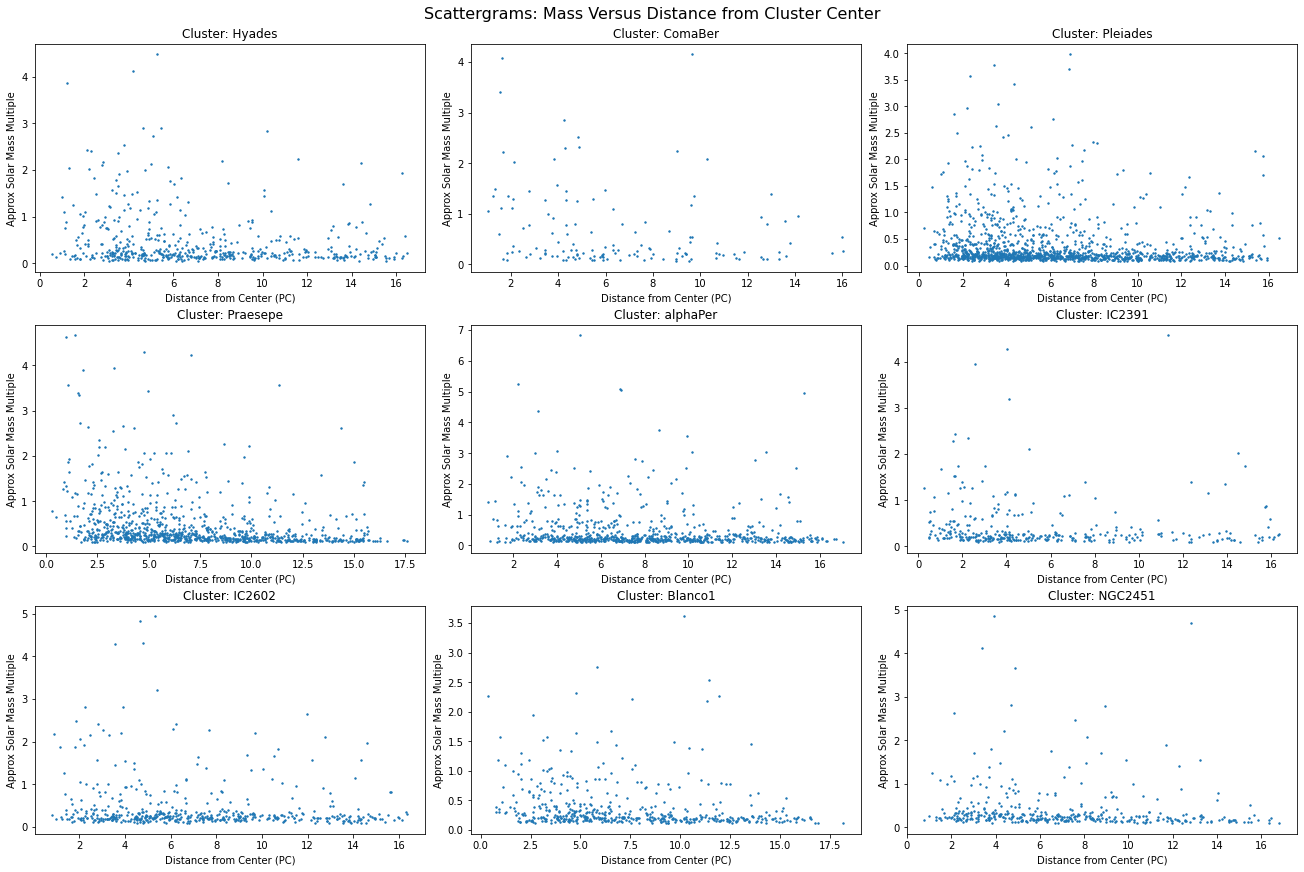

In [6]:

fig = plt.figure(figsize=(18,12), constrained_layout=True)
axs = fig.subplots(3,3)
for cl, ax in zip(cluster_names, axs.flatten()):
    ax.scatter(cluster_members[cl].objs.CenDist, cluster_members[cl].objs.MassProxy, s=2)
    ax.set_ylabel('Approx Solar Mass Multiple')
    ax.set_xlabel('Distance from Center (PC)')
    ax.set_title(f'Cluster: {cl}')
    
zz=fig.suptitle('Scattergrams: Mass Versus Distance from Cluster Center', size=16)

In [7]:
import matplotlib.colors as colors
import matplotlib as mpl

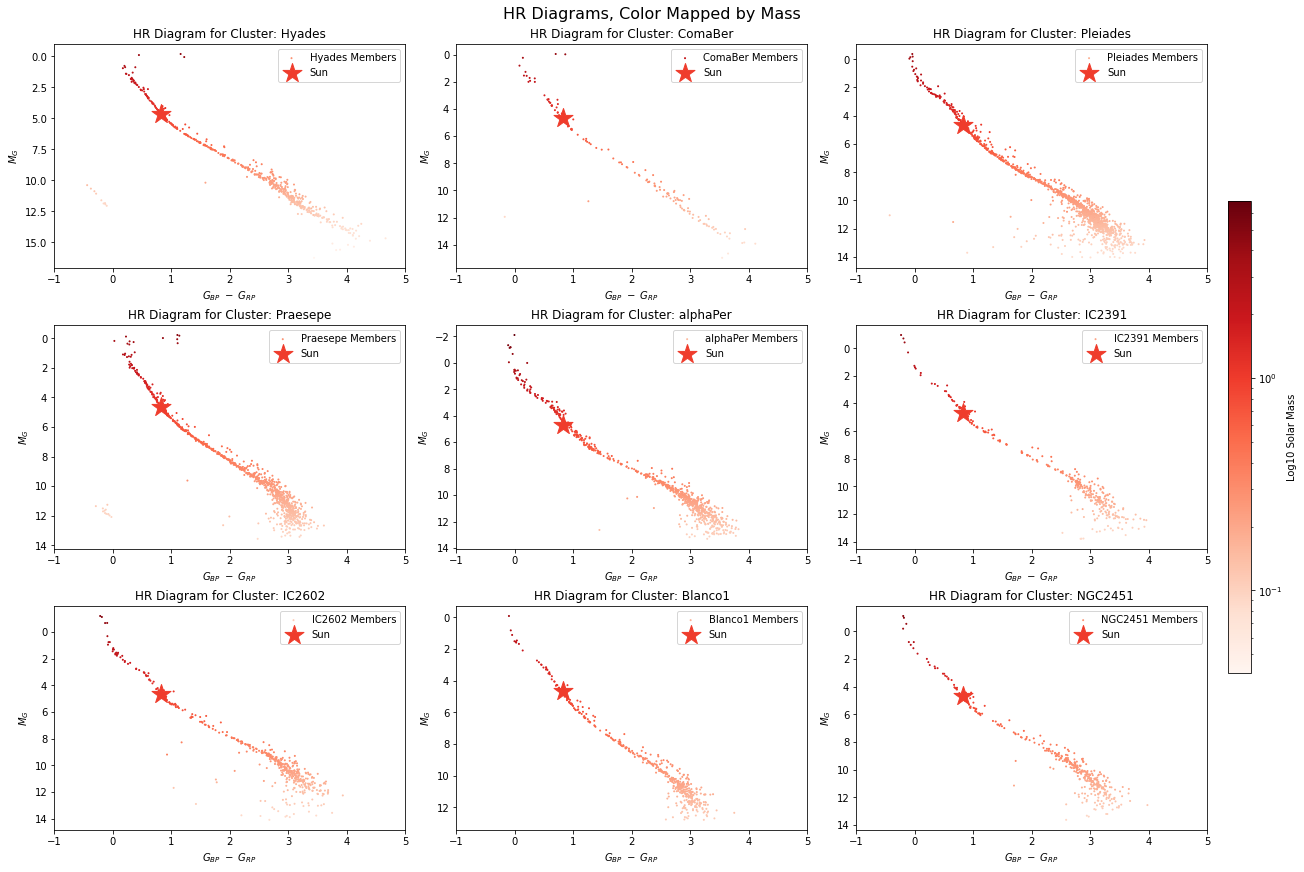

In [8]:
#get min/max mass
vmin = np.array([cluster_members[cl].objs.MassProxy.min() for cl in cluster_names]).min()
vmax = np.array([cluster_members[cl].objs.MassProxy.max() for cl in cluster_names]).max()
fig = plt.figure(figsize=(18,12), constrained_layout=True)
axs = fig.subplots(3,3)
for cl, ax in zip(cluster_names, axs.flatten()):

    cb = cluster_members[cl].plot_hrdiagram(ax=ax,c=cluster_members[cl].objs.MassProxy,
                                            cmap='Reds',norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                             label=f'{cl} Members')
    ax.scatter(np.array([sun['G_BP-G_RP']]), np.array([sun['G']-sun['distmod']]), marker='*', s=400,
                  cmap='Reds',norm=colors.LogNorm(vmin=vmin, vmax=vmax), c=np.array([1.00]), label='Sun')
    ax.legend()
    ax.set_title(f'HR Diagram for Cluster: {cl}')

fig.colorbar(cb, ax=axs[:,2:], location='right', shrink=0.6, label='Log10 Solar Mass')
zz=fig.suptitle('HR Diagrams, Color Mapped by Mass', size=16)

/home/kevin_leo_mcmanus/anaconda3/envs/astroml/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Use the colorbar set_ticks() method instead.
/home/kevin_leo_mcmanus/anaconda3/envs/astroml/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator


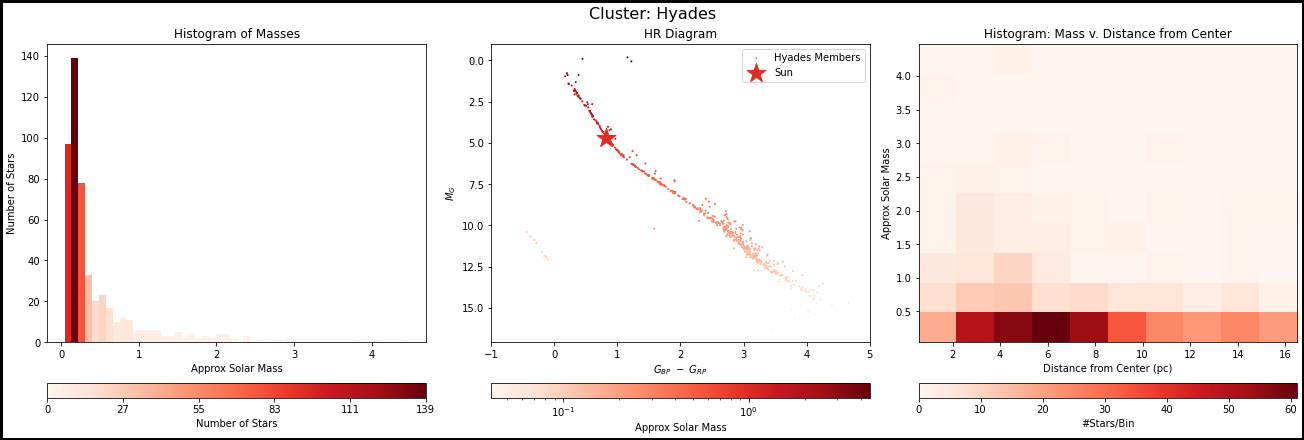

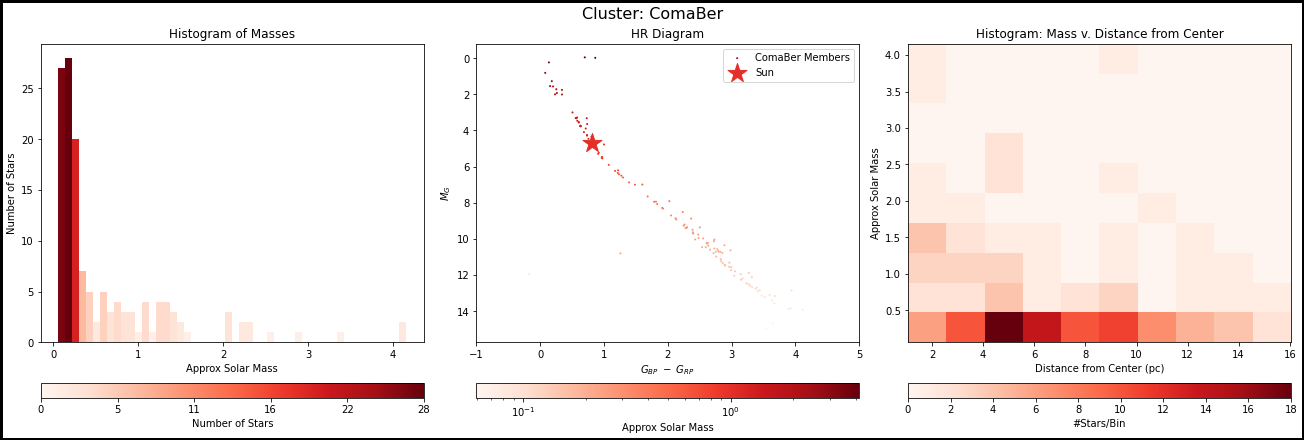

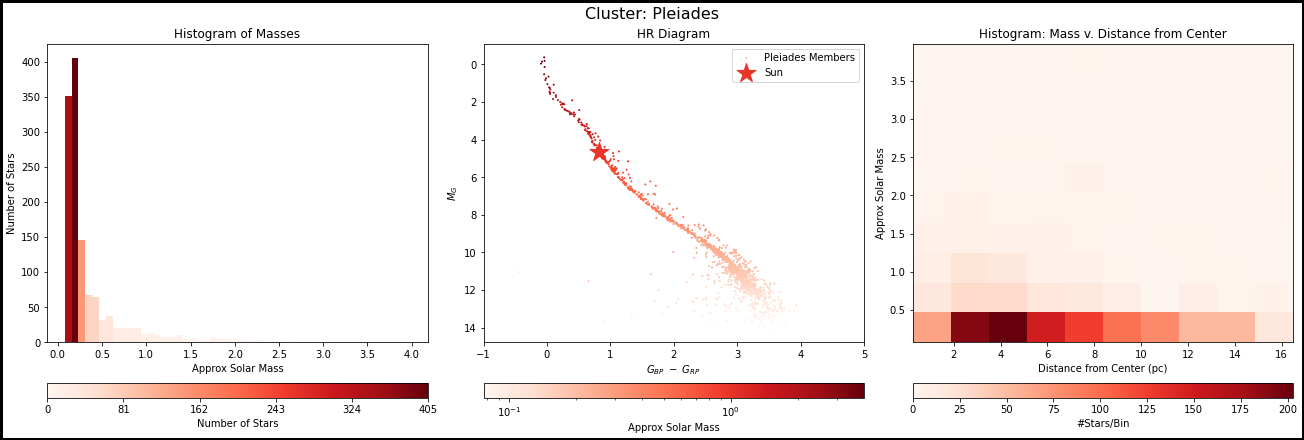

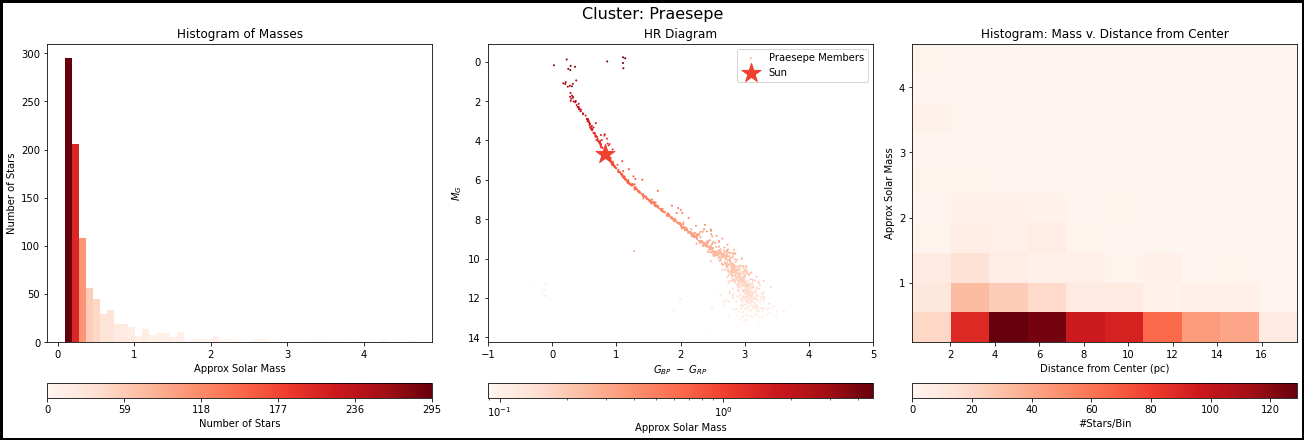

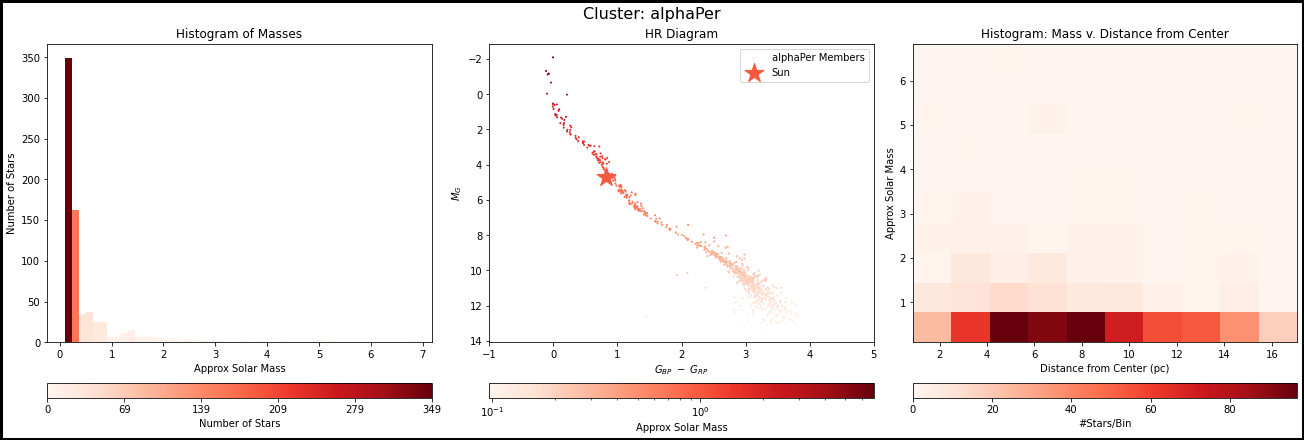

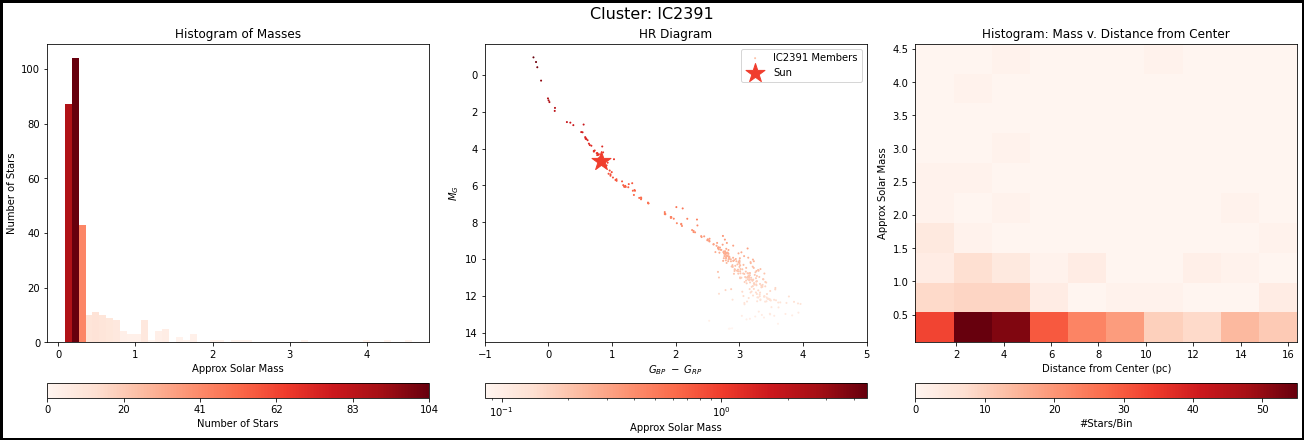

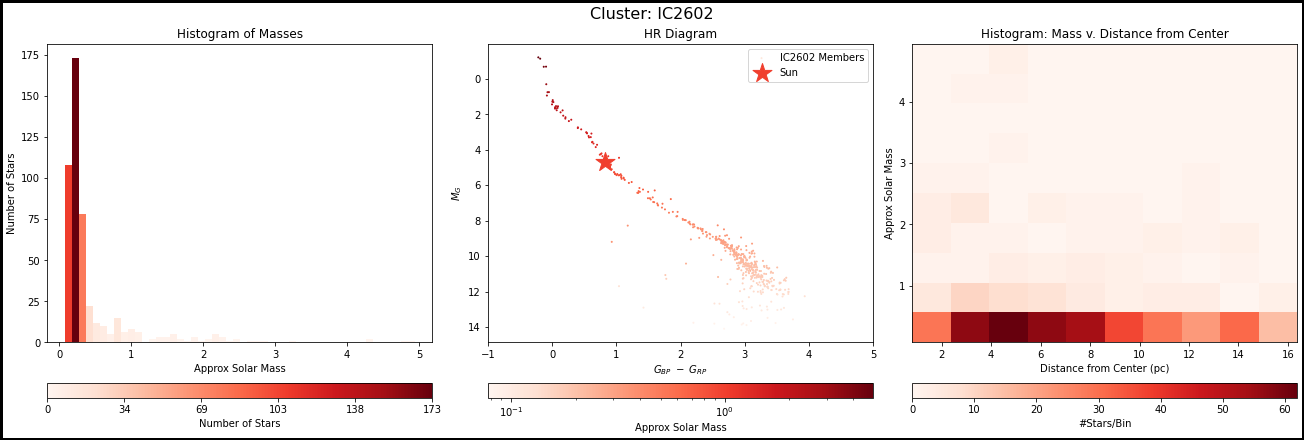

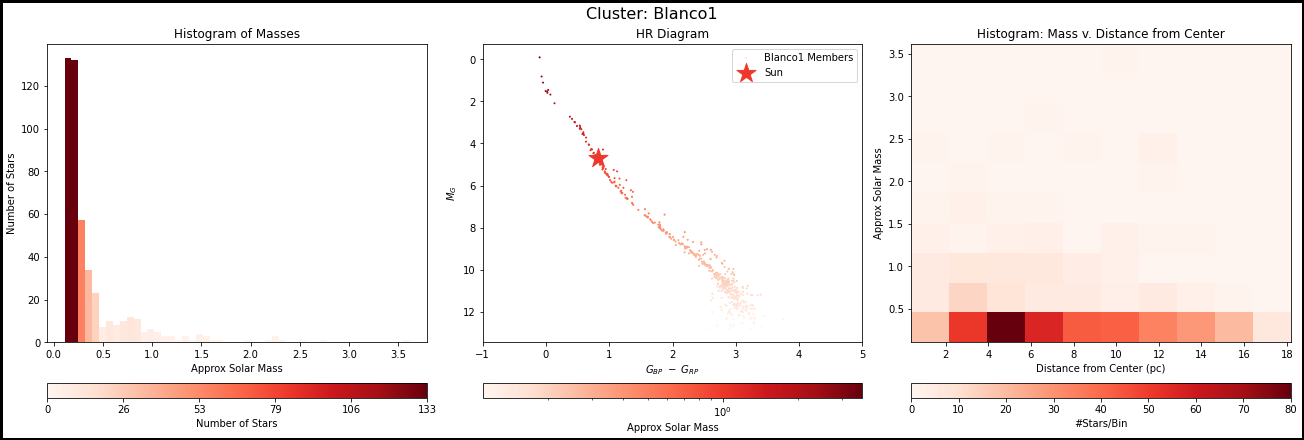

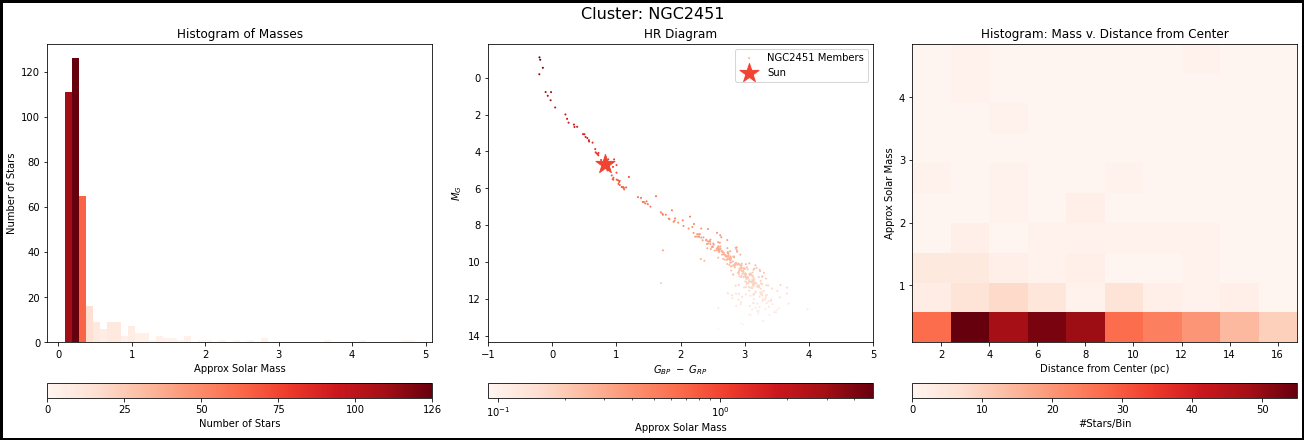

In [9]:
for cl in cluster_names:
    fig = plt.figure(figsize=(18,6), constrained_layout=True, linewidth=5, edgecolor='black')
    gs = fig.add_gridspec(2,3,height_ratios=[1,0.05])
    hmass = fig.add_subplot(gs[0,0])
    hmass_cbax = fig.add_subplot(gs[1,0])
    
    hrd = fig.add_subplot(gs[0,1])
    hrd_cbax = fig.add_subplot(gs[1,1])
    
    h2d = fig.add_subplot(gs[0,2])
    h2d_cbax = fig.add_subplot(gs[1,2])
    
    cm = plt.cm.get_cmap('Reds')
    n, bins, patches=hmass.hist(cluster_members[cl].objs.MassProxy, bins=50)
    col = (n-n.min())/(n.max()-n.min())
    for c,p in zip(col,patches):
        plt.setp(p,'facecolor',cm(c))
    hmass.set_xlabel('Approx Solar Mass')
    hmass.set_ylabel('Number of Stars')
    hmass.set_title('Histogram of Masses')
    
    #colorbar:
    v1 = np.linspace(n.min(), n.max(), 6, endpoint=True)
    cb_hmass = mpl.colorbar.ColorbarBase(hmass_cbax, orientation='horizontal', label='Number of Stars',
                                  cmap=plt.cm.Reds)
    cb_hmass.ax.set_xticks(v1)
    cb_hmass.ax.set_xticklabels([f'{int(t):d}' for t in v1])
    
    vmax = cluster_members[cl].objs.MassProxy.max();vmin=cluster_members[cl].objs.MassProxy.min()
    cb = cluster_members[cl].plot_hrdiagram(ax=hrd,c=cluster_members[cl].objs.MassProxy,
                                            cmap='Reds',norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                             label=f'{cl} Members')
    hrd.scatter(np.array([sun['G_BP-G_RP']]), np.array([sun['G']-sun['distmod']]), marker='*', s=400,
                  cmap='Reds',norm=colors.LogNorm(vmin=vmin, vmax=vmax), c=np.array([1.00]), label='Sun')
    fig.colorbar(cb, cax = hrd_cbax, orientation='horizontal', label='Approx Solar Mass')
    hrd.legend()
    
    valid=np.isfinite(cluster_members[cl].objs.MassProxy)
    counts, xedges, yedges, im = h2d.hist2d(cluster_members[cl].objs.CenDist[valid], cluster_members[cl].objs.MassProxy[valid],
                                            #bins=[ distbins, massbins],
                                            cmap='Reds')
    h2d.set_title('Histogram: Mass v. Distance from Center')
    h2d.set_ylabel('Approx Solar Mass')
    h2d.set_xlabel('Distance from Center (pc)')
    fig.colorbar(im, cax=h2d_cbax, orientation='horizontal', label='#Stars/Bin', shrink=0.6)
    plt.suptitle(f'Cluster: {cl}', fontsize=16)
    

## Binned Data

In [10]:
binwidth = 2 #pc
maxdist = 16 #pc
bins = np.arange(0, maxdist, binwidth)
bin_mids = np.arange(len(bins))*binwidth+binwidth/2
for cl in cluster_members:
    cluster_members[cl].objs['DistBin']= np.digitize(cluster_members[cl].objs.CenDist,bins)

In [11]:
mass_seg = {}
for cl in cluster_names:

    mass_seg[cl]= pd.DataFrame([(b,g.CenDist.mean(), g.MassProxy.mean(), g.MassProxy.std(),np.isfinite(g.MassProxy).sum()) for b, g in cluster_members[cl].objs.groupby('DistBin')],
                              columns=['Bin','MeanDist','MeanMass','StdDev','BinCount'])
    mass_seg[cl]['BinMid'] = bin_mids[mass_seg[cl].Bin-1]

In [12]:
mass_seg['Pleiades']

,Bin,MeanDist,MeanMass,StdDev,BinCount,BinMid
0,1,1.427709,0.504589,0.493781,115,1.0
1,2,3.034267,0.452324,0.544377,331,3.0
2,3,4.920820,0.367621,0.421998,281,5.0
3,4,6.954361,0.420397,0.576989,213,7.0
4,5,8.993601,0.282717,0.324414,133,9.0
5,6,10.950535,0.247096,0.275586,99,11.0
6,7,12.967083,0.327376,0.334613,86,13.0
7,8,14.928652,0.362045,0.468671,49,15.0


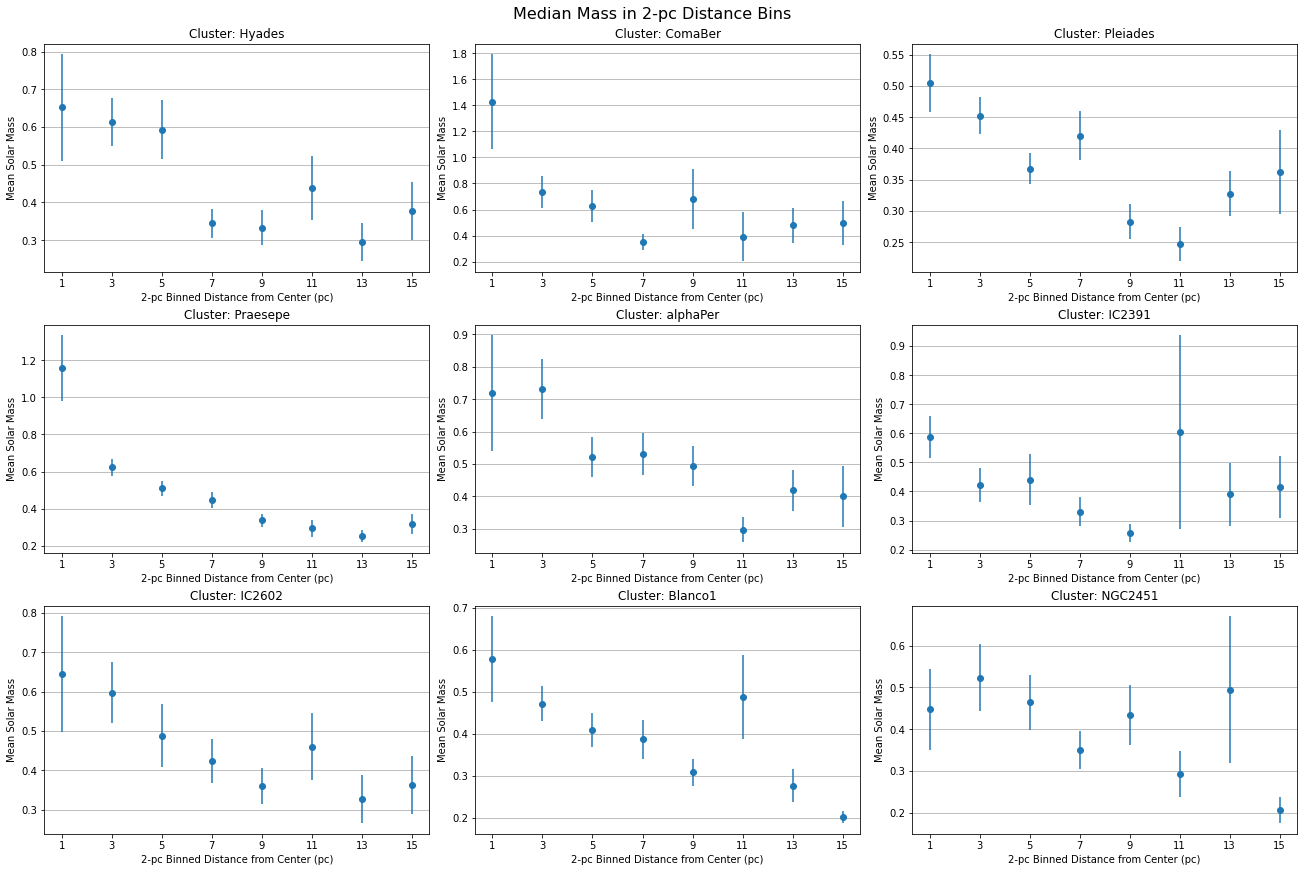

In [13]:
fig = plt.figure(figsize=(18,12), constrained_layout=True)
axs = fig.subplots(3,3)
for cl,ax in zip(cluster_names, axs.flatten()):

    #ax.plot(mass_seg['Pleiades'].MeanDist, mass_seg['Pleiades'].MeanMass,marker='o', linestyle='None')
    ax.errorbar(mass_seg[cl].BinMid, mass_seg[cl].MeanMass, mass_seg[cl].StdDev/np.sqrt(mass_seg[cl].BinCount), fmt='o')
    ax.set_title(f'Cluster: {cl}')
    ax.set_xlabel('2-pc Binned Distance from Center (pc)')
    ax.set_ylabel('Mean Solar Mass')
    ax.set_xticks(mass_seg[cl].BinMid)
    ax.grid(axis='y')
    
zz=fig.suptitle('Median Mass in 2-pc Distance Bins', size=16)

In [14]:
distbins=np.concatenate([bins[:-1],np.array([np.inf])])
distbins

array([ 0.,  2.,  4.,  6.,  8., 10., 12., inf])

In [15]:
massbins = np.array([0,0.125,0.25, 0.5, 1.0, 1.5, np.inf])

`h` is mass x distance. `h.sum(axis=0)` gives len(distbins), the total number of objects in each distance bin; similarly, `h.sum(axis=1)` gives len(mass bins), total number of objects in each mass bin

## Goodness of Fit Test

Build RC contingency table.

$$
\chi_{dof}^2 = \sum_{i=1}^R\sum_{j=1}^C \frac{O_{i,j}-E_{i,j}}{E_{i,j}}
$$
where $R$ = number of mass bins and $C$ is number of distance bins.  $dof = (R-1)(C-1)$

Hypothesis Test:
$$
H_0:\ No\ Segregation\ apparent \
$$
$$
H_1:\ Segregation\ apparent
$$

In [26]:
from scipy.stats import chi2

In [38]:
from scipy.stats import chi2

def chi_2way(x,y, bin_x, bin_y, alpha=0.01):
    #x is rows, y is columns
    
    # ditch the nans
    valid = np.logical_and(np.isfinite(x), np.isfinite(y))
    obs_x = x[valid]; obs_y = y[valid]
    
    # calc the contingency table 
    contingency_table, xb, yb = np.histogram2d(obs_x, obs_y, (bin_x, bin_y))

    #marginal frequencies
    N = contingency_table.sum()
    x_prob = contingency_table.sum(axis=1).reshape(-1,1)/N
    y_prob = contingency_table.sum(axis=0).reshape(1,-1)/N
    
    #expected value in each cell and chi square value
    expected = x_prob.dot(y_prob)*N
    chi_val = np.sum( ((contingency_table-expected)**2)/expected ) 
    
    #degrees of freedom
    # len(bin_x) and len(bin_y) is one more than the number of bins in each
    # because they contain the end points; so need to subtract two below
    n_bins_x = len(bin_x)-1
    n_bins_y = len(bin_y)-1
    dof = (n_bins_x-1)*(n_bins_y-1)
    
    #critical chi value
    crit = chi2.ppf(1.0-alpha, dof)
    
    return chi_val, dof, alpha, crit, expected, contingency_table
    

In [30]:
def bins_to_strs(bins, r):
    strs = [str(bins[i-1])+' <= '+ r+' < '+str(bins[i]) for i in range(1,len(bins))]
    return strs
    

In [31]:
import matplotlib.gridspec as gridspec
def plot_contingency_table(tbl, bins, ax, cmap='Reds', vrng=None, fmt='{:.0f}'):
    
    if vrng is not None:
        vmin = vrng[0]
        vmax = vrng[1]
    else:
        vmin=vmax=None
    minx = tbl.min(); maxx=tbl.max()
    cb = ax.imshow(tbl, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    for i in range(len(bins[0][:-1])):
        for j in range(len(bins[1][:-1])):
            color = 'white' if (tbl[i,j]-minx)/(maxx-minx)>0.8 else 'black'
            ax.text(j,i, fmt.format(tbl[i,j]),ha='center', color=color, fontweight='bold')
    ax.set_yticklabels(['']+bins_to_strs(bins[0],'SolarMass')+[''])
    ax.set_xticklabels(['']+bins_to_strs(bins[1],'CenDist')+[''], rotation=90, ha='center')
    ax.set_xlabel('Binned Distance from Center (pc)')
    ax.set_ylabel('Binned Solar Mass Multiple')

    return cb
    

/home/kevin_leo_mcmanus/anaconda3/envs/astroml/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/home/kevin_leo_mcmanus/anaconda3/envs/astroml/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


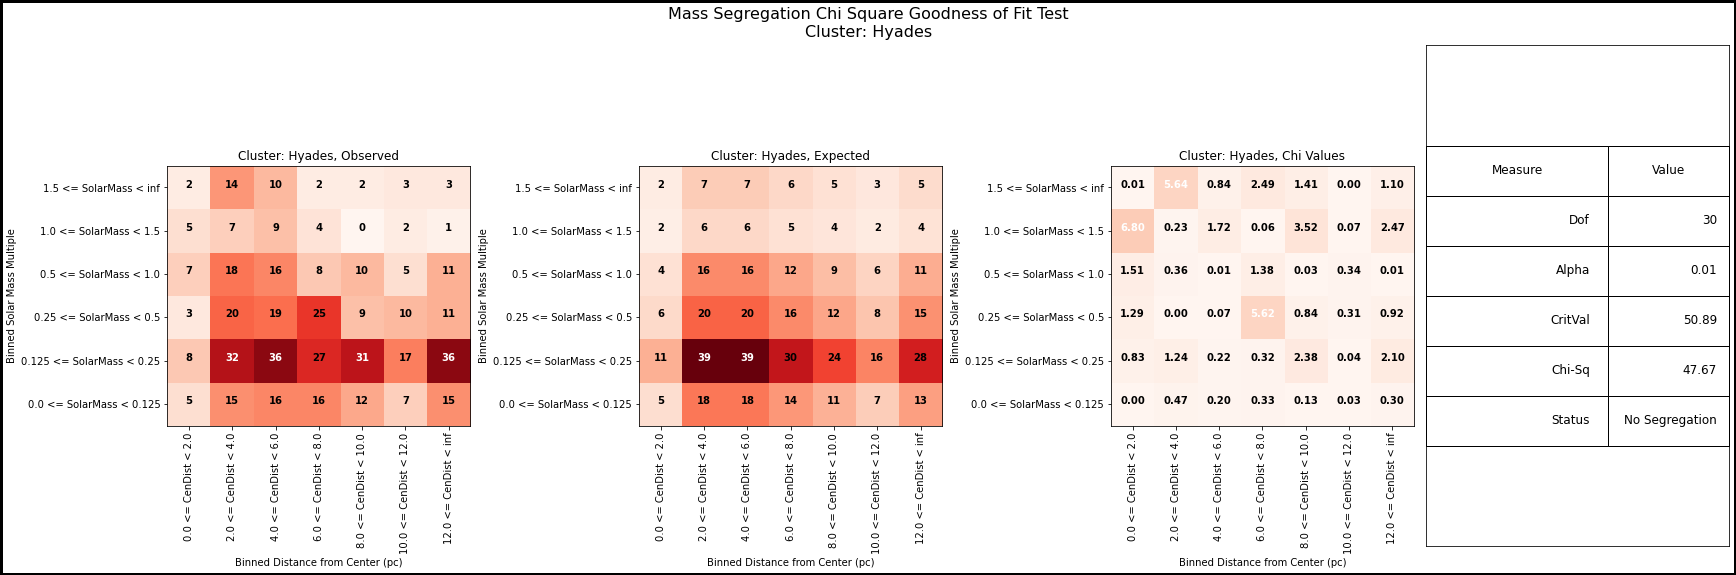

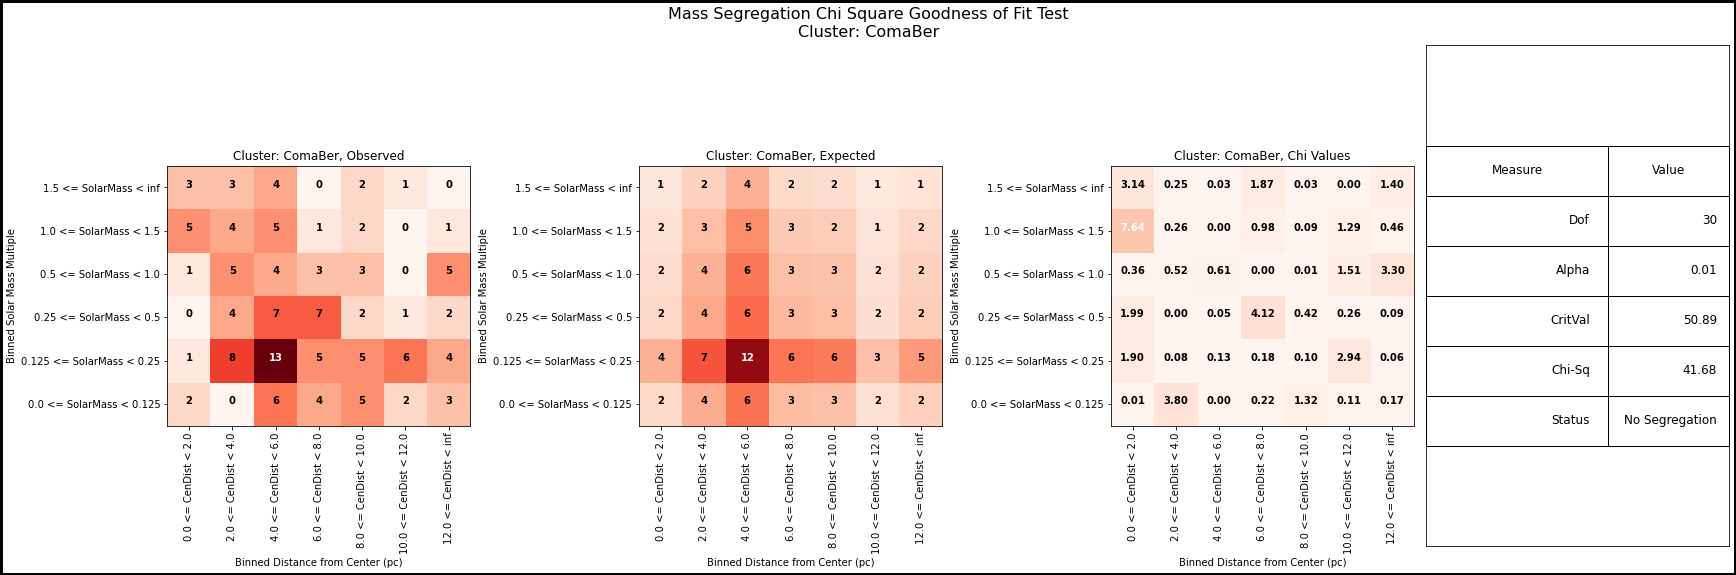

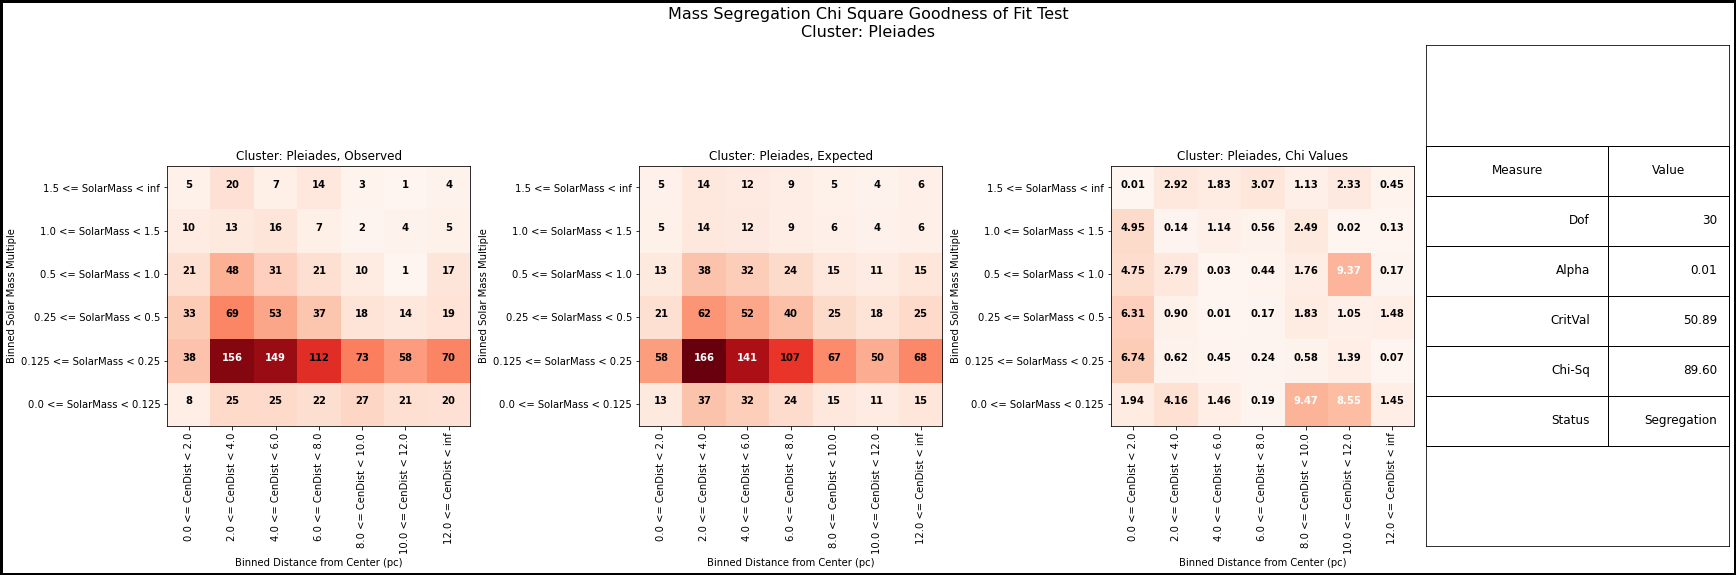

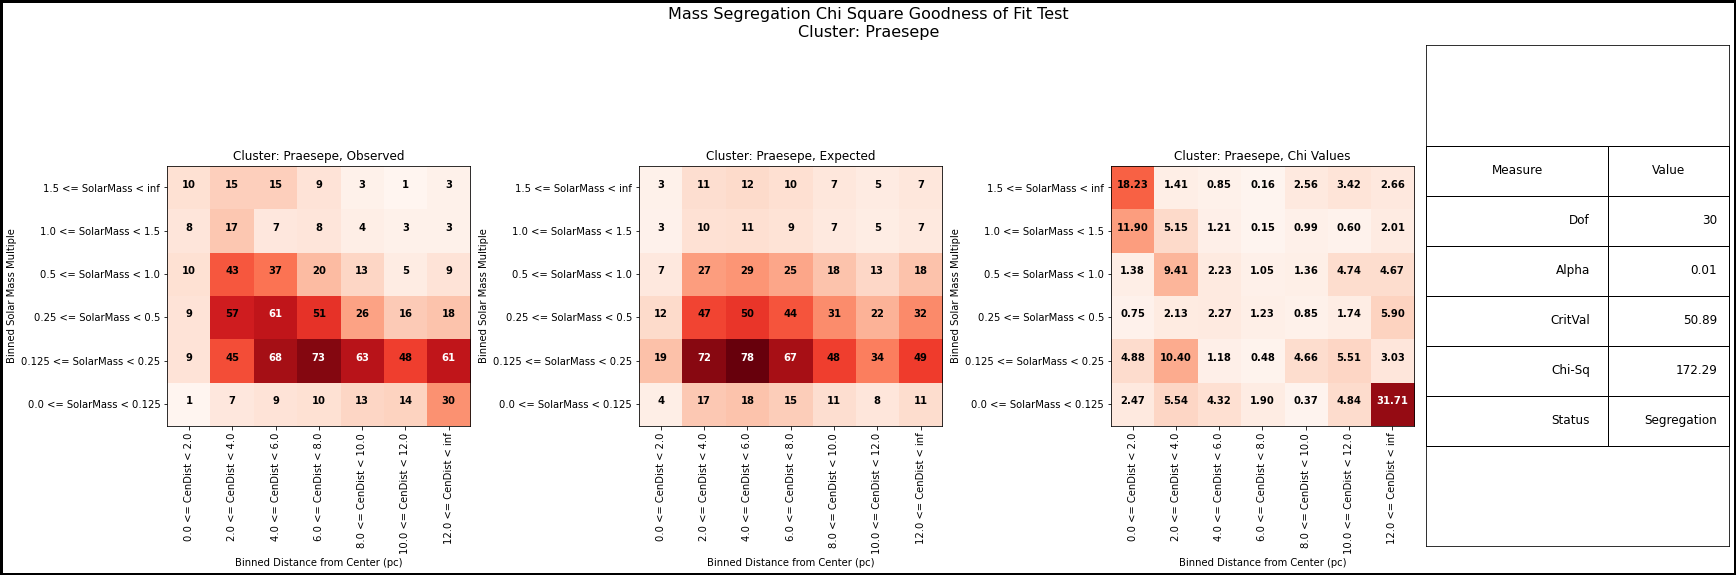

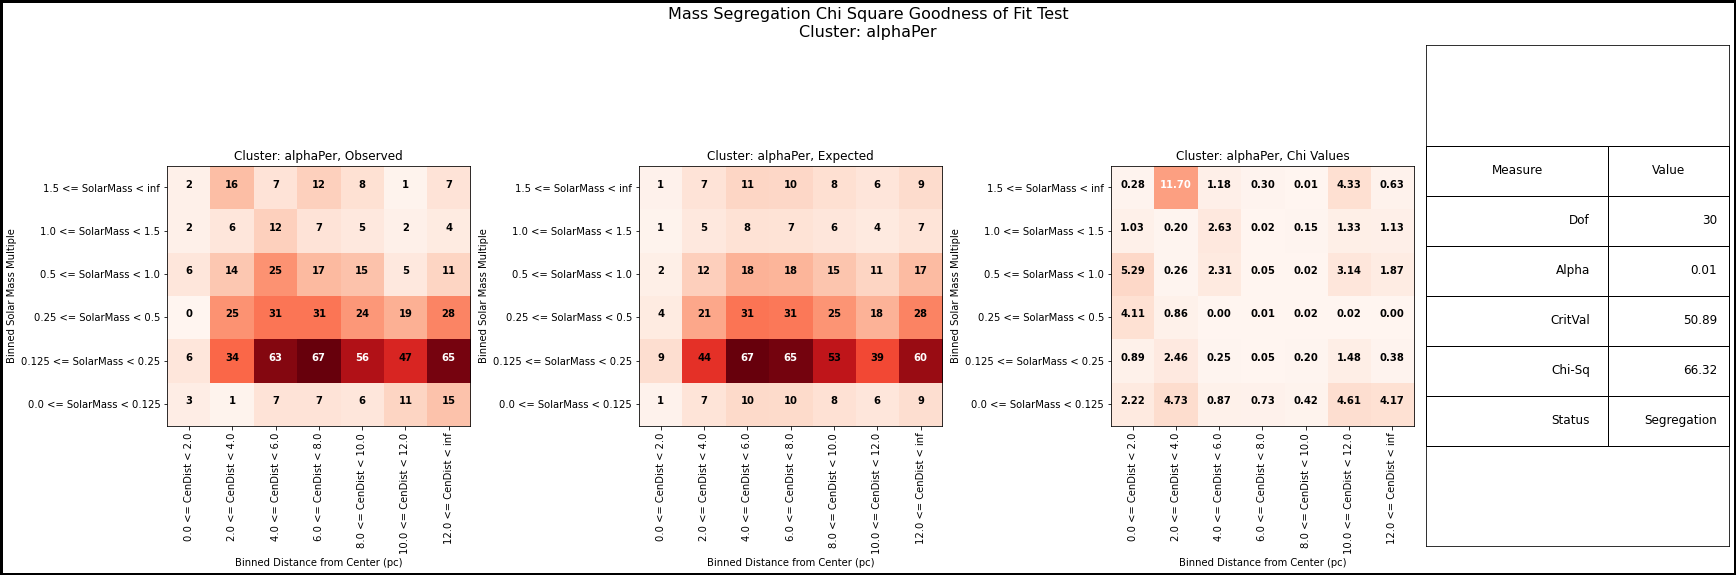

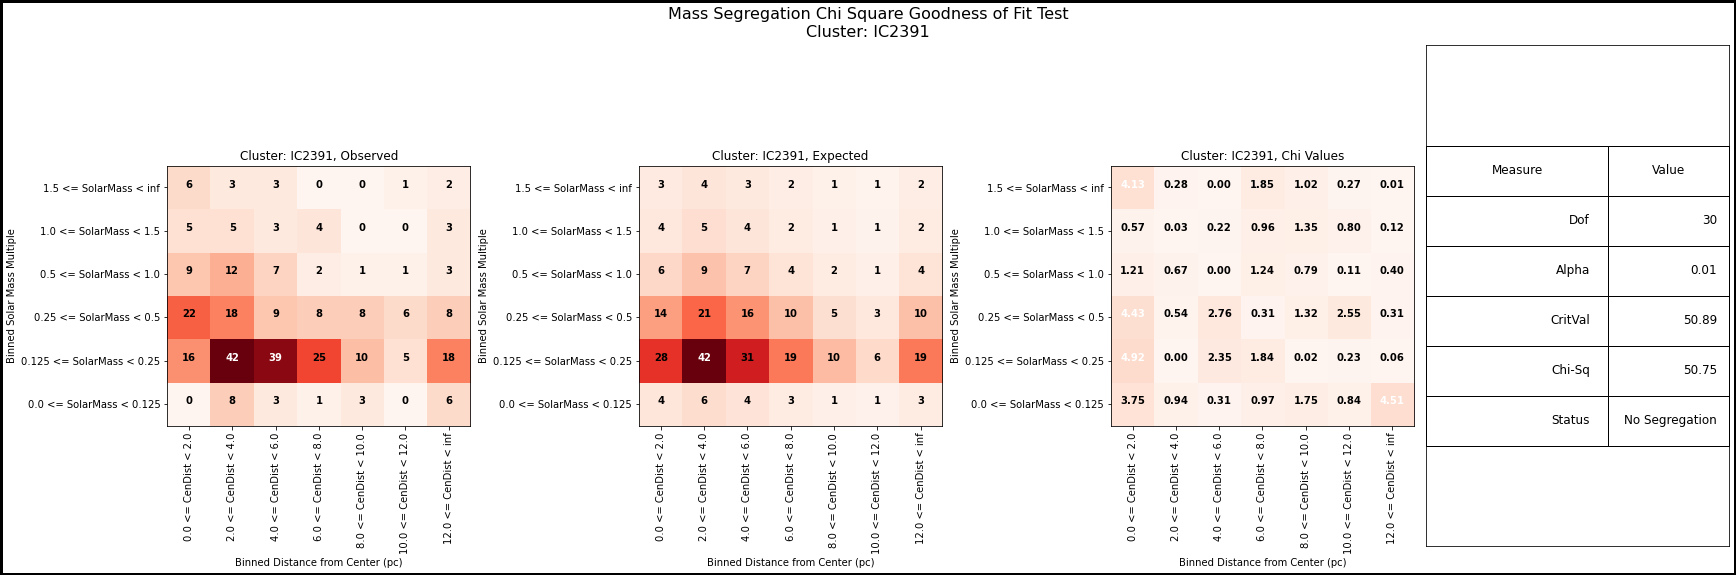

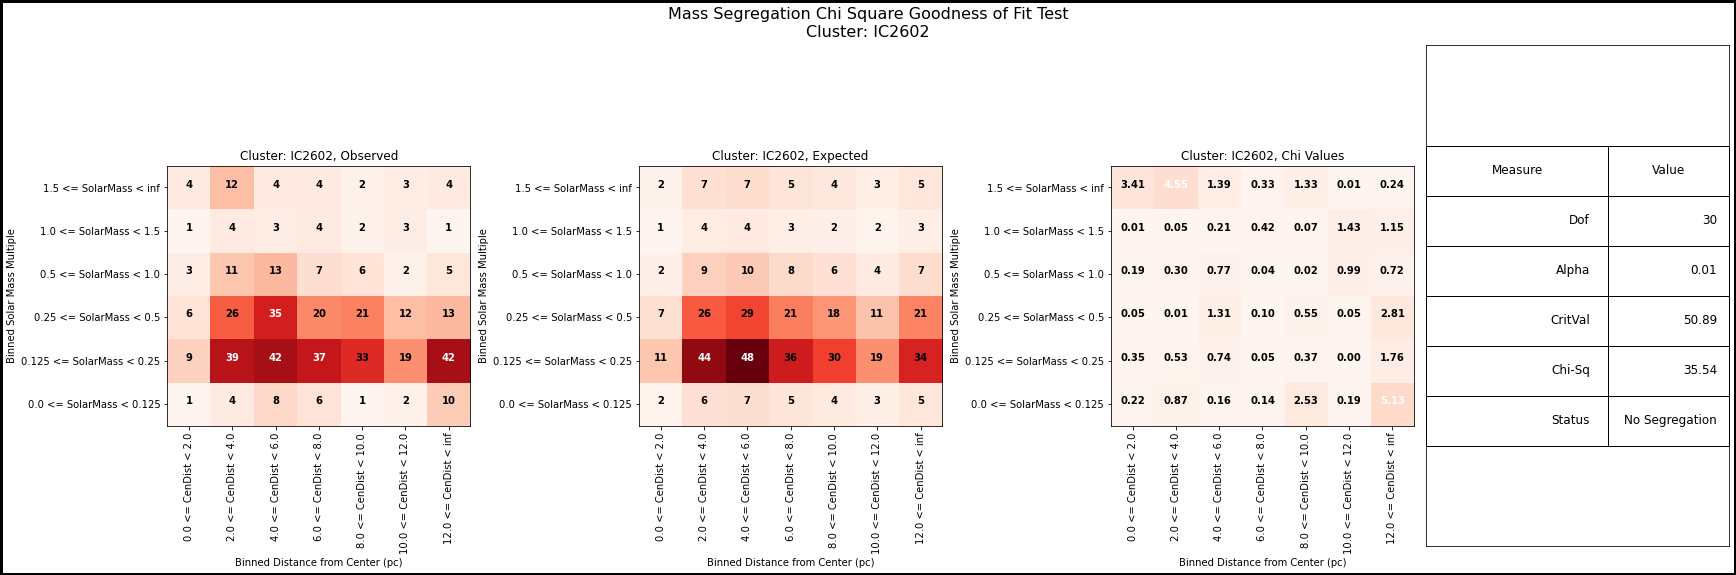

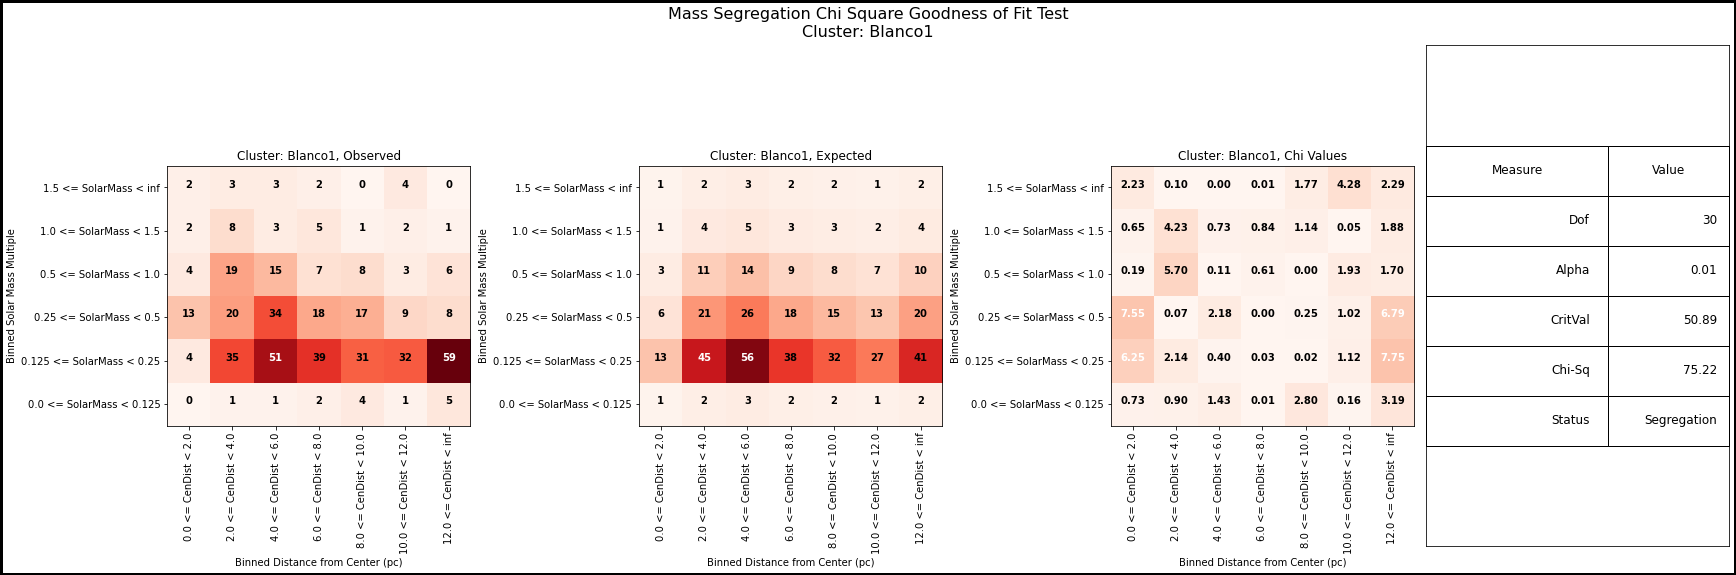

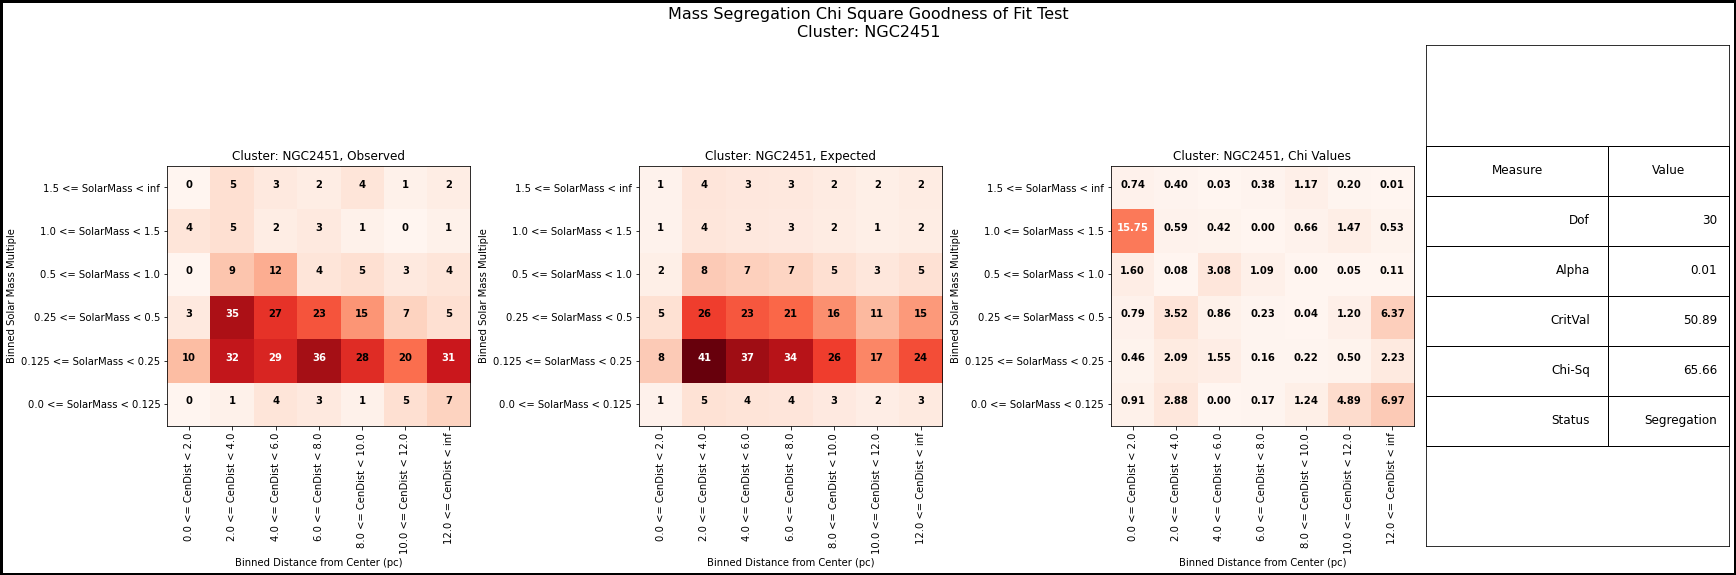

In [42]:
for cl in cluster_names:
    fig = plt.figure(figsize=(24,8), constrained_layout=True,linewidth=5, edgecolor='black')
    ax = fig.subplots(1,4)
    
    cv, dof, alpha, crit, expd, obs = chi_2way(cluster_members[cl].objs.MassProxy, cluster_members[cl].objs.CenDist, massbins, distbins)
    vmin= min(expd.min(), obs.min())
    vmax = max(expd.max(), obs.max())
    
    plot_contingency_table(obs,(massbins,distbins),ax[0],vrng=(vmin,vmax))
    ax[0].set_title(f'Cluster: {cl}, Observed')
    
    plot_contingency_table(expd, (massbins, distbins),ax[1],vrng=(vmin,vmax))
    ax[1].set_title(f'Cluster: {cl}, Expected')
    

    chi_tbl = ((obs-expd)**2)/expd
    plot_contingency_table(chi_tbl, (massbins, distbins),ax[2], vrng=(0.0, 35.0),fmt='{:.2f}')
    ax[2].set_title(f'Cluster: {cl}, Chi Values')
    

    result_str = 'Segregation' if cv > crit else 'No Segregation'
    tbl = ax[3].table(colLabels = ['Measure', 'Value'],
                     cellText = [
                         ['Dof', f'{dof:d}'],
                         ['Alpha', f'{alpha:.2f}'],
                         ['CritVal', f'{crit:.2f}'],
                         ['Chi-Sq', f'{cv:.2f}'],
                         ['Status', f'{result_str}']
                     ],
                    colWidths=[0.6, 0.4],
                    bbox=[0.0, 0.20, 1.0, 0.6])
    
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(12)
    for a in [ax[3]]:
        a.xaxis.set_major_formatter(plt.NullFormatter())
        a.yaxis.set_major_formatter(plt.NullFormatter())
        a.set_yticks([])
        a.set_xticks([])

    fig.suptitle(f'Mass Segregation Chi Square Goodness of Fit Test\nCluster: {cl}', size=16)
    #result_str = 'Evidence of Mass Segregation' if cv > crit else 'No Evidence of Mass Segregation'
    #print(f'Cluster: {cl}, Chi Square Value: {cv:.3f}, Critical Value: {crit:.3f}, Result: {result_str}')